# Nonlinear Buckling Analysis of a Box Beam Reinforced with Ribs

***

In this notebook we are going to investigate the nonlinear buckling behavior of a box beam reinforced with ribs.

* [Geometry and material properties](#geometry)
* [Setup of the numerical model](#numerical-model)
* [Mesh convergence study](#mesh-convergence)
* [Nonlinear analysis: sensitivity of nonlinear analysis parameters](#nonlinear-analysis-parameters)
    * [Error function](#error-function)
    * [Convergence tolerance](#convergence-tolerance)
    * [Initial load increment](#ninc)
    * [Desired number of iteration](#desiter)
    * [Minimum allowable arc-length adjustment ratio](#minalr)
    * [Maximum allowable arc-length adjustment ratio](#maxalr)
* [Nonlinear analysis: nonlinear buckling method verification](#nonlinear-buckling-method-verification)
* [Conclusion](#conclusion)

## Geometry and material properties <a name="geometry"></a>

***

We consider an analogous box beam to our previous notebooks. However, this time we reinforce it with a number of equally spaced ribs along the length.

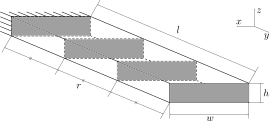

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '08_BoxBeamGeometry.svg'))

Let's define the planform and the cross-section of our box beam.

In [2]:
AR = 9   # aspect ratio - 2*b/w (the length of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
l = AR*w/2  # length [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- length: {l/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

Box beam dimensions:
- width: 1.0 m
- length: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


Next we define the ribs' spacing to be half the width of the box beam and we calculate the corresponding locations along the length.

In [3]:
import numpy as np

ribs_spacing = w/2  # half of box beam's width
no_ribs = int(np.ceil(l/ribs_spacing)) + 1  # calculate number of ribs
ribs_y_locations = np.linspace(0, l, no_ribs)  # calculate y-coordinates of the ribs

# Print information to screen
np.set_printoptions(precision=0)
print(f'Number of ribs: {no_ribs:.0f}')
print(f'Ribs\' y-coordinate [mm]:')
print(ribs_y_locations)

Number of ribs: 10
Ribs' y-coordinate [mm]:
[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]


Finally, we define the material properties.

In [4]:
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

## Setup of the numerical model <a name="numerical-model"></a>

***

We employ the python package [`pyvista`](https://github.com/pyvista/pyvista) to generate a mesh of our reinforced box beam.

We use the function `mesh_box_beam_with_pyvista` from the `box_beam_utils` module, which calls the following two functions:
- `mesh_box_with_pyvista`, which generates a mesh of a box segment without ribs;
- `mesh_rib_with_pyvista`, which generates a mesh of a rib.

Both functions enforce the discretization of every edge of the geometry with an odd number of nodes, which results in a better approximation of the buckling shape. After calling the two mentioned functions, `mesh_box_beam_with_pyvista` combines the box and rib meshes together to generate the final mesh, which is returned as a `PolyData` object. This object containes the coordinates of the nodes and their connectivity information.

Let's select a shell element with a target lenght equal to the height of the box beam and let's generate the corresponding mesh. We then plot the mesh using the `plot` method of the `PolyData` class.

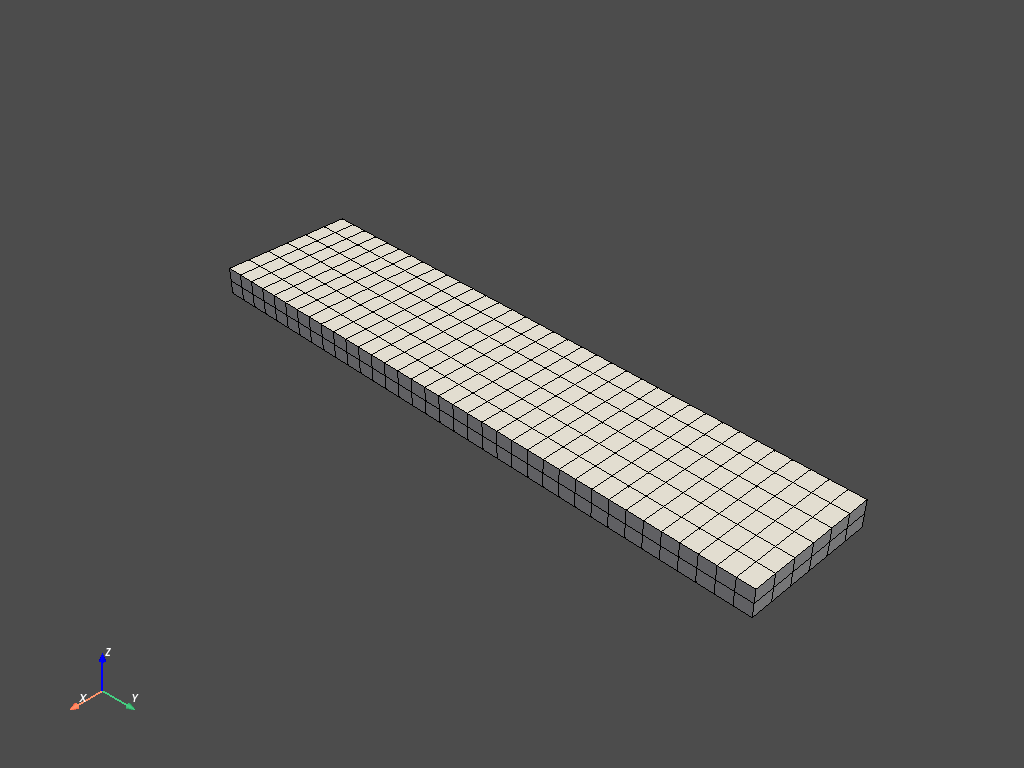

In [5]:
from resources import box_beam_utils

example_box_beam_mesh = box_beam_utils.mesh_box_beam_with_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h, element_length=h)
example_box_beam_mesh.plot(show_edges=True, jupyter_backend='static')

Following the mesh we need to create a base bdf input, that we will complete each time depending on the analysis we want to perform. For this purpose we use the function `create_base_bdf_input` from the `box_beam_utils` module. This function takes as input the following:
 - material Young's modulus, Poisson's ratio and density;
 - cross-sectional thickness (same for the whole structure);
 - array with coordinates of the nodes;
 - array with connectivity matrix.

It returns a `BDF` object with the following:
 - `MAT1` card defining an isotropic material;
 - `PSHELL` card defining the properties of the shell elements;
 - `GRID` cards defining the nodes;
 - `CQUAD4` cards defining the quadrilateral shell elements;
 - `SPC1` card defining the clamped boundary condition at the box beam root;
 - `PARAM` cards and case control commands to set up the boundary condition and the ouput files.

Let's find the coordinates of the nodes and the connectivity matrix from the example mesh created earlier, call `create_base_bdf_input` and print a summary of our bdf input.

In [6]:
nodes_xyz_array = example_box_beam_mesh.points  # Nx3 array with the xyz coordinates of the nodes
nodes_connectivity_matrix = example_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]  # Nx4 array with the indices of the nodes defining each element in each row
example_bdf_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t,
                                                         nodes_xyz_array=nodes_xyz_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(example_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 642

bdf.elements: 0
  CQUAD4   : 696

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Now it's time to define our load. Analogously to the case of the unreinforced box beam, we are going to consider a concentrated bending load applied at the tip, as shown below. We define the function `apply_tip_concentrated_load` that performs the following steps:

- adds a master node at the center of the tip section;
- connects the master node to the nodes on the edge of the tip rib with a `RBE3` element, which defines the motion at a reference grid point as the weighted average of the motions at a set of other grid points;
- applies a unitary vertical force at the master point with a `FORCE` card.

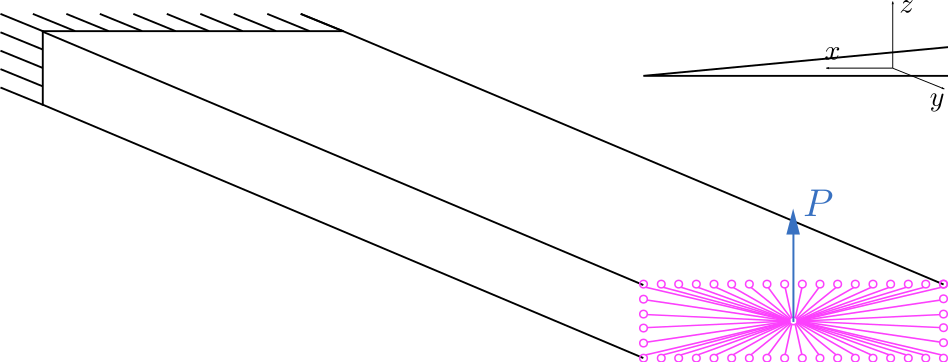

In [7]:
SVG(filename=os.path.join('resources', '08_BoxBeamConcentratedLoad.svg'))

In [8]:
from resources import pynastran_utils

def apply_tip_concentrated_load(bdf_input, force_id):
    # Add master node at the center of the tip section
    master_node_id = len(bdf_input.nodes) + 1
    bdf_input.add_grid(master_node_id, [w/2, l, 0.])
    # Find id of the nodes on the edge of the tip rib
    tolerance = t/10  # we define a geometric tolerance to find the nodes on the edge of the tip rib equal to 1/10 of the cross-sectional stiffness
    tip_edge_nodes_ids = [nid for nid in bdf_input.nodes if (np.abs(bdf_input.nodes[nid].xyz[1] - l) < tolerance) &
                          (np.abs((bdf_input.nodes[nid].xyz[0]) < tolerance) | (np.abs(bdf_input.nodes[nid].xyz[0] - w) < tolerance) |
                           (np.abs(bdf_input.nodes[nid].xyz[2] - h/2) < tolerance) | (np.abs(bdf_input.nodes[nid].xyz[2] + h/2) < tolerance))]
    # Add RBE3 to connect master node with edge nodes of tip rib
    rbe3_eid = len(bdf_input.elements) + 1
    bdf_input.add_rbe3(eid=rbe3_eid, refgrid=master_node_id, refc='123456', weights=[1.]*len(tip_edge_nodes_ids),
                       comps=['123456']*len(tip_edge_nodes_ids), Gijs=tip_edge_nodes_ids)
    # Add concentrated force
    force_direction = [0., 0., 1.]
    pynastran_utils.add_unitary_force(bdf_object=bdf_input, nodes_ids=[master_node_id], set_id=force_id, direction_vector=force_direction)
    # Return id of master node
    return master_node_id

## Mesh convergence study <a name="mesh-convergence"></a>

***

Analogously to what we did for the [unreinforced box beam](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb#mesh-convergence), we need run a mesh convergence study to establish an appropriate mesh size for our analyses. For this reason, we define 10 different linear sizes for the shell elements, evenly spaced on a log scale between half and 1/20 of the height of the box beam, and we monitor how the linear buckling load changes.

In [9]:
# Define shell elements' edge lengths to be used for the mesh convergence study and print them to screen
shell_element_lengths = np.geomspace(h/2, h/20, 10) # [mm]
print("Target length of shell elements for mesh convergence study [mm]:")
print(shell_element_lengths)

Target length of shell elements for mesh convergence study [mm]:
[100.  77.  60.  46.  36.  28.  22.  17.  13.  10.]


subcase=0 already exists...skipping



Results of model with:
    - 100 mm prescribed edge length
    - 1496 elements
    - 8262 degrees of freedom
Buckling load: 3172 N
Buckling mode:


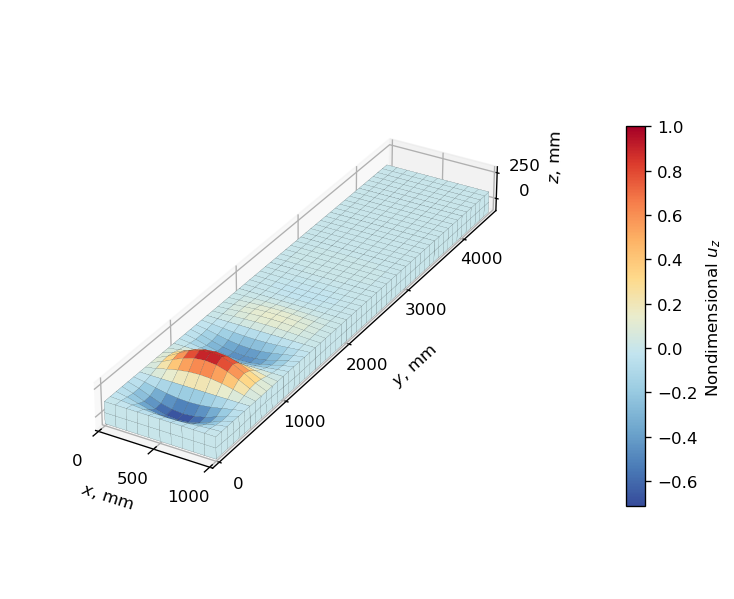

subcase=0 already exists...skipping



Results of model with:
    - 77 mm prescribed edge length
    - 3152 elements
    - 17658 degrees of freedom
Buckling load: 3120 N
Buckling mode:


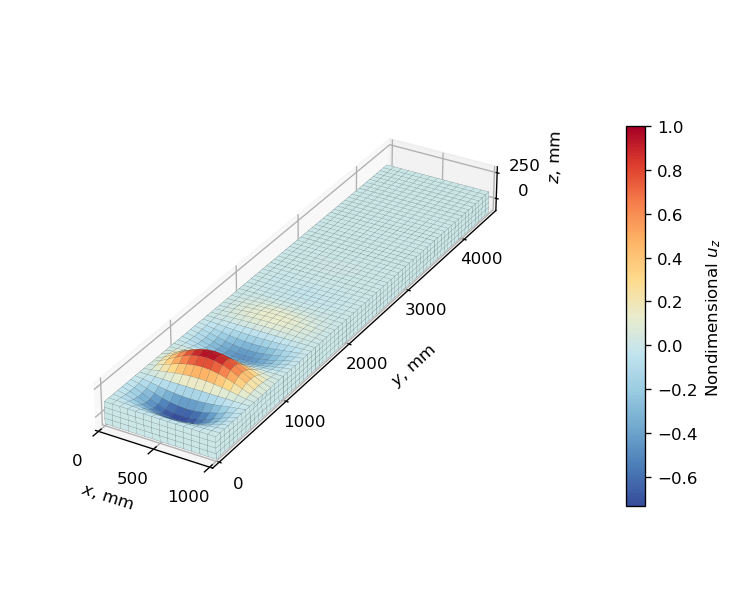

subcase=0 already exists...skipping



Results of model with:
    - 60 mm prescribed edge length
    - 4680 elements
    - 26514 degrees of freedom
Buckling load: 3101 N
Buckling mode:


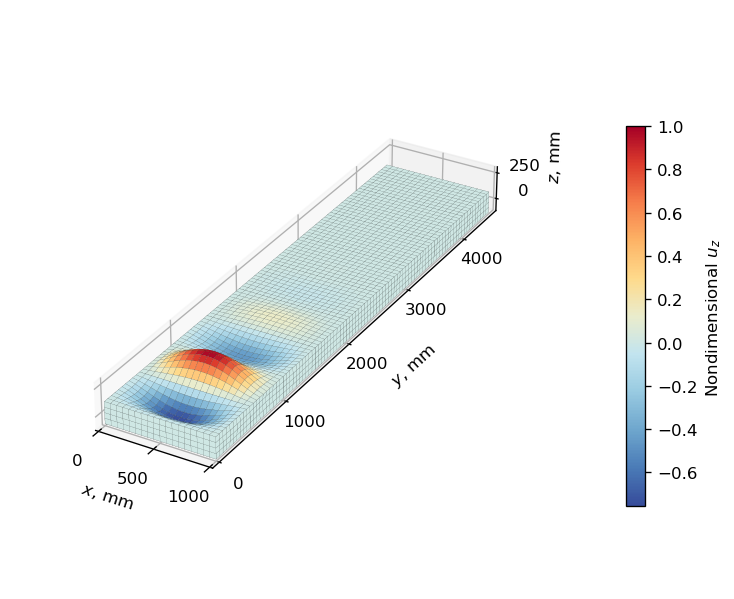

subcase=0 already exists...skipping


Nastran job linear_buckling_7368_elements.bdf completed
Wall time: 3.0 s



Results of model with:
    - 46 mm prescribed edge length
    - 7368 elements
    - 41958 degrees of freedom
Buckling load: 3094 N
Buckling mode:


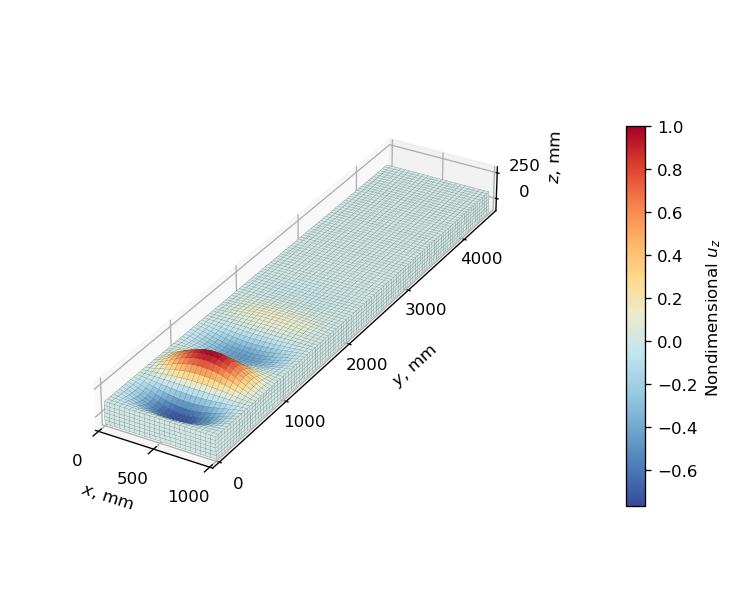

subcase=0 already exists...skipping


Nastran job linear_buckling_10248_elements.bdf completed
Wall time: 5.0 s



Results of model with:
    - 36 mm prescribed edge length
    - 10248 elements
    - 58698 degrees of freedom
Buckling load: 3089 N
Buckling mode:


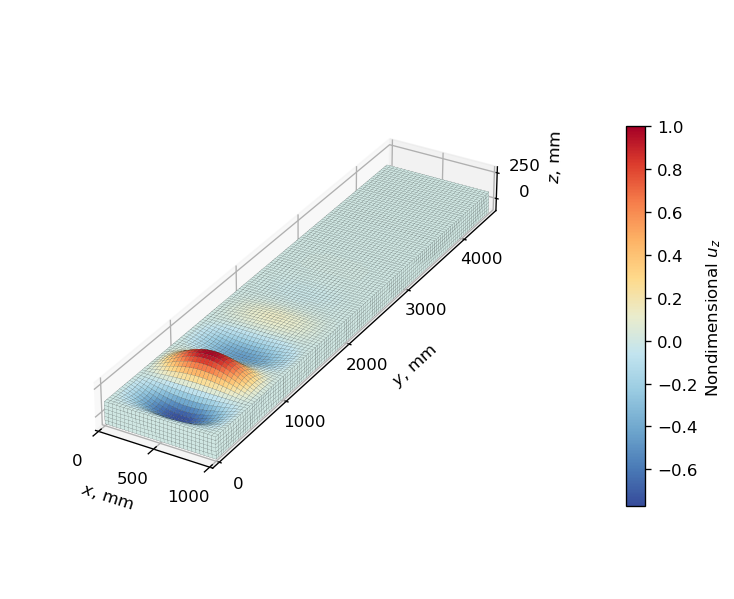

subcase=0 already exists...skipping


Nastran job linear_buckling_17136_elements.bdf completed
Wall time: 11.0 s



Results of model with:
    - 28 mm prescribed edge length
    - 17136 elements
    - 98766 degrees of freedom
Buckling load: 3086 N
Buckling mode:


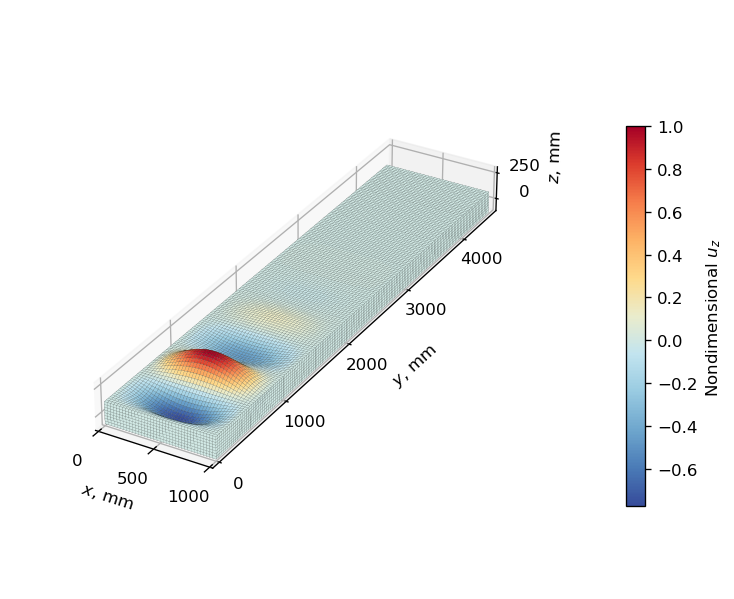

subcase=0 already exists...skipping


Nastran job linear_buckling_29856_elements.bdf completed
Wall time: 17.0 s



Results of model with:
    - 22 mm prescribed edge length
    - 29856 elements
    - 173178 degrees of freedom
Buckling load: 3083 N
Buckling mode:


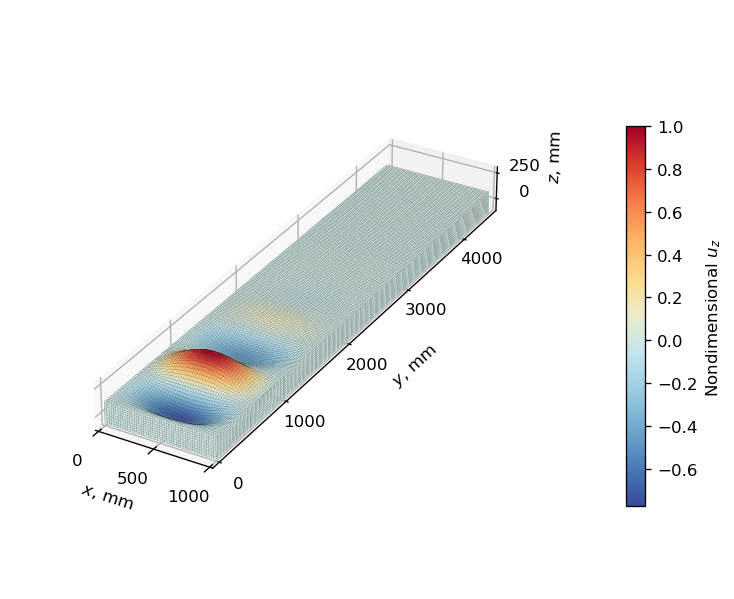

subcase=0 already exists...skipping


Nastran job linear_buckling_46080_elements.bdf completed
Wall time: 29.0 s



Results of model with:
    - 17 mm prescribed edge length
    - 46080 elements
    - 268326 degrees of freedom
Buckling load: 3082 N
Buckling mode:


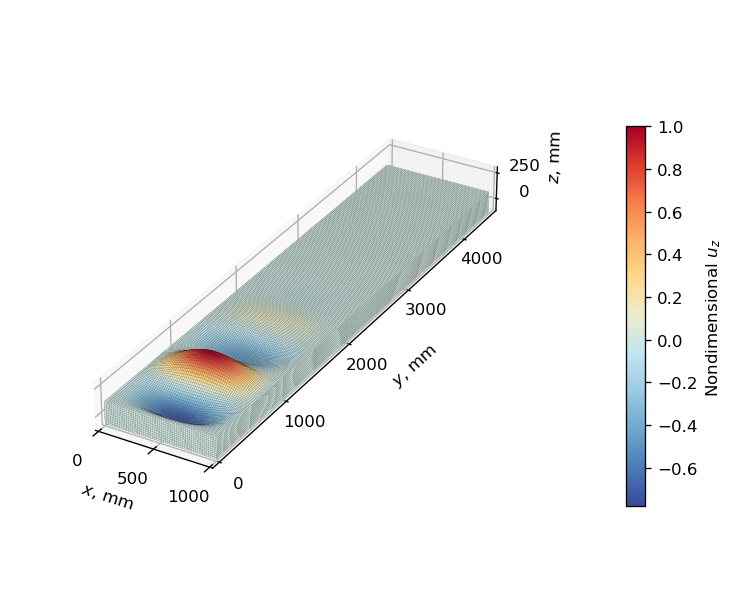

subcase=0 already exists...skipping


Nastran job linear_buckling_80160_elements.bdf completed
Wall time: 63.0 s



Results of model with:
    - 13 mm prescribed edge length
    - 80160 elements
    - 468450 degrees of freedom
Buckling load: 3082 N
Buckling mode:


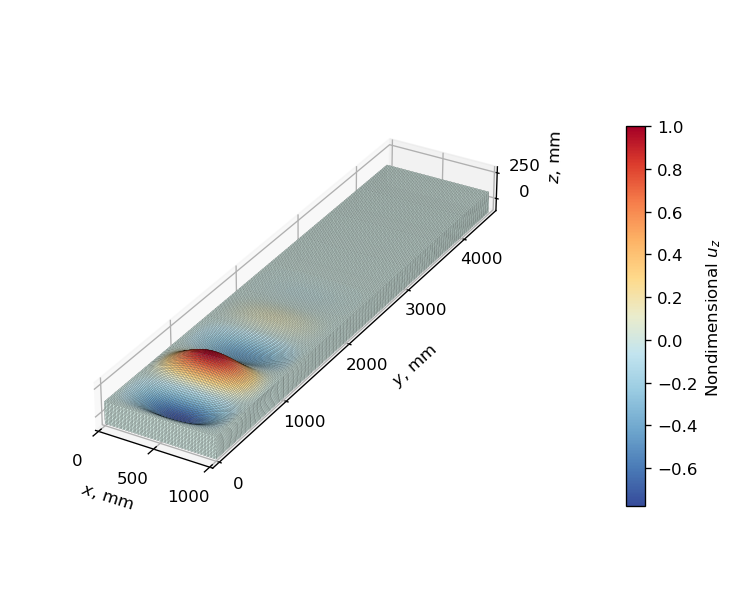

subcase=0 already exists...skipping


Nastran job linear_buckling_128000_elements.bdf completed
Wall time: 140.0 s



Results of model with:
    - 10 mm prescribed edge length
    - 128000 elements
    - 749574 degrees of freedom
Buckling load: 3081 N
Buckling mode:


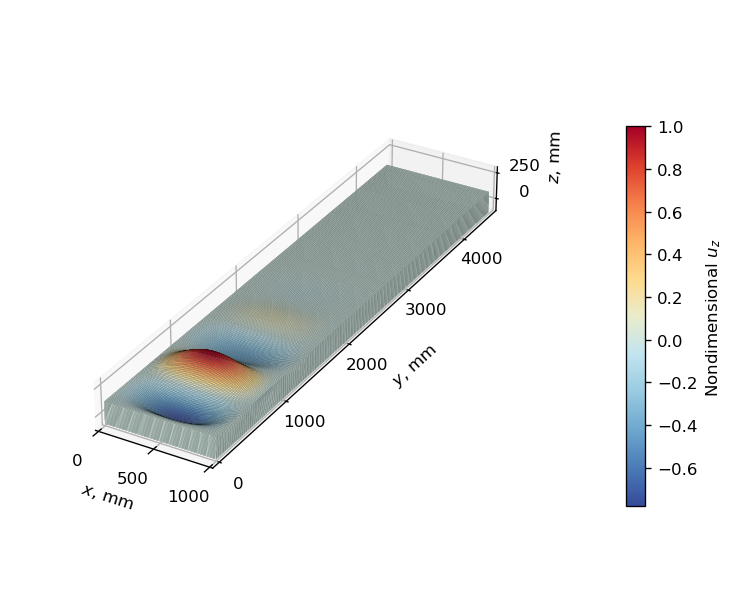

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120  # set default dpi of figures
force_set_id = 11  # define FORCE card identification number
buckling_subcase_id = 2  # define buckling subcase id

# Initialize arrays with number of elements, number of degrees of freedom and linear buckling loads
no_elements = np.empty(np.shape(shell_element_lengths), dtype=int)
dofs = np.empty(np.shape(shell_element_lengths), dtype=int)
linear_buckling_loads = np.empty(np.shape(shell_element_lengths))

# Define name of analysis directory
analysis_directory_name = '08_Nonlinear_Buckling_Analysis_of_a_Reinforced_Box_Beam'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar):
    axes.locator_params(axis='x', nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis='y', which='major', pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis='z', which='major', pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(0, .14))  # move colorbar upwards

# Iterate through the different edge lengths
for count, element_length in enumerate(shell_element_lengths):
    # Generate bdf input
    box_beam_mesh = box_beam_utils.mesh_box_beam_with_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h,
                                                              element_length=element_length)
    nodes_xyz_array = box_beam_mesh.points
    nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
    linear_buckling_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t,
                                                               nodes_xyz_array=nodes_xyz_array,
                                                               nodes_connectivity_matrix=nodes_connectivity_matrix)
    # Store number of elements and number of degrees of freedom of current model
    no_elements[count] = len(linear_buckling_bdf.elements)
    constrained_nodes_ids = next(iter(linear_buckling_bdf.spcs.values()))[0].node_ids
    dofs[count] = (len(linear_buckling_bdf.nodes) - len(constrained_nodes_ids))*6
    # Apply uniform load over the top skin
    apply_tip_concentrated_load(linear_buckling_bdf, force_set_id)
    # Run SOL 105 and return OP2 object
    input_name = 'linear_buckling_' + str(no_elements[count]) + '_elements'
    sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=linear_buckling_bdf.__deepcopy__({}), static_load_set_id=force_set_id,
                                                                analysis_directory_path=analysis_directory_path, input_name=input_name,
                                                                run_flag=False)
    # Find critical buckling load and print it
    print(f"""\n\033[1mResults of model with:
    - {element_length:.0f} mm prescribed edge length
    - {no_elements[count]:d} elements
    - {dofs[count]:d} degrees of freedom\033[0m""")
    linear_buckling_loads[count] = sol_105_op2.eigenvectors[buckling_subcase_id].eigr
    print(f"Buckling load: {linear_buckling_loads[count]:.0f} N")
    # Plot critical buckling mode
    print("Buckling mode:")
    _, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=2, displacement_component='tz', colormap='sunset')
    adjust_3d_plot(ax, cbar)
    plt.show()

We plot the buckling loads and the percentage difference with respect to the one obtained with the finest mesh against the number of degrees of freedom.

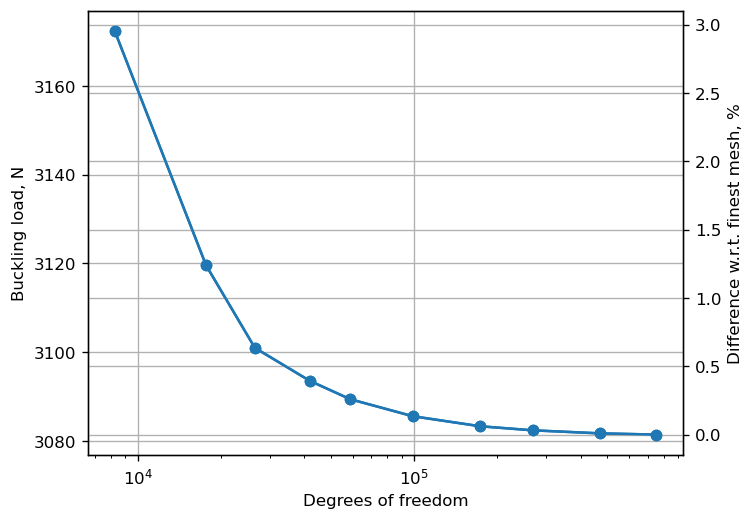

In [11]:
# Plot buckling loads vs degrees of freedom with a log scale along the x-axis
fig, ax1 = plt.subplots()  # create a figure and set of axes
buckling_load_line = ax1.semilogx(dofs, linear_buckling_loads, 'o-')

# Create a twin set of axes to plot percentage difference vs degrees of freedom
ax2 = ax1.twinx()
percentage_diff = (linear_buckling_loads/linear_buckling_loads[-1]-1)*100
percentage_diff_line = ax2.plot(dofs, percentage_diff, 'o-')

# Set plot appearance
ax1.set_xlabel("Degrees of freedom")
ax1.set_ylabel("Buckling load, N")
ax2.set_ylabel("Difference w.r.t. finest mesh, %")
ax1.grid(True)
ax2.grid(True)
plt.show()


We see that the linear buckling load decreases monotonically and it converges to a value just above 3080 N. We define the mesh to be converged when the percentage difference with respect to the buckling load obtained with the finest mesh falls below 1%.

In [12]:
converged_mesh_index = np.where(np.abs(percentage_diff) < 1)[0][0]  # find index of the edge length array corresponding to where the percentage difference is below 1
converged_element_length = shell_element_lengths[converged_mesh_index]  # store shell length of converged mesh
sol_105_buckling_load = linear_buckling_loads[converged_mesh_index]  # store buckling load of converged mesh
print(f"""The mesh is converged for a prescribed shell element length of {converged_element_length:.0f} mm,
corresponidng to {no_elements[converged_mesh_index]:d} elements, {dofs[converged_mesh_index]:d} degrees of freedom
and to a linear buckling load of {sol_105_buckling_load:.0f} N.""")

The mesh is converged for a prescribed shell element length of 60 mm,
corresponidng to 4680 elements, 26514 degrees of freedom
and to a linear buckling load of 3101 N.


We remind that the linear buckling load predicted by SOL 105 for the unreinforced box beam under a concentrated bending load was 1654 N. Consequently, we can say that the addition of the ribs results in almost doubling the linear buckling load.

## Nonlinear analysis: sensitivity of nonlinear analysis parameters <a name="nonlinear-analysis-parameters"></a>

***

Now we want to assess the influence of SOL 106's nonlinear analysis parameters on the results of the analysis. Analogously to what we did for the [unreinforced box beam](05_Sensitivity_Study_of_SOL_106_Nonlinear_Analysis_Parameters.ipynb), we are going to vary several parameters of the `NLPARM` and the `NLPCI` cards and we are going to look at how the load-displacement diagram changes, monitoring the tip displacement.

To perform our investigation we create a base bdf input of the box beam using the element length obtained from the mesh convergence study. Then we set up SOL 106 with the arc-length method, starting with the default Nastran parameters.

In [13]:
box_beam_mesh = box_beam_utils.mesh_box_beam_with_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h,
                                                          element_length=converged_element_length)
nodes_xyz_array = box_beam_mesh.points
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t,
                                                    nodes_xyz_array=nodes_xyz_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
pynastran_utils.set_up_arc_length_method(box_beam_bdf)  # set up SOL 106 with arc-length method using default parameters

subcase=0 already exists...skipping


The last steps before starting our study consist in applying the concentrated force at the tip, defining an applied load equal to twice the buckling load predicted by SOL 105, and creating the corresponding subcase.

In [14]:
tip_master_node_id = apply_tip_concentrated_load(box_beam_bdf, force_set_id)  # add FORCE card
load_set_id = force_set_id + 1  # define id of load set
box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[sol_105_buckling_load*2], load_ids=[force_set_id])  # add LOAD card to define load set with twice the buckling load predicted by SOL 105
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=1, load_set_id=load_set_id)  # create subcase with defined load set

### Error function <a name="error-function"></a>

Let's start our investigation with the error function. We consider four different combinations of error functions:
- load and energy (default);
- load and energy with vector component checking;
- load and displacement;
- load and displacement with vector component checking;
- load, energy and displacement;
- load, energy and displacement with vector component checking.

In [15]:
error_functions = ['PW', 'PWV', 'PU', 'PUV', 'PWU', 'PWUV']


Since we need to plot the load-displacement diagram for different values of the nonlinear analysis parameters, we define a list of markers to use in the plots. We also define the function `plot_load_displacement_diagram` to run the Nastran analysis, read the load and displacement history from the op2 file and plot the load-displacement curve on a pre-defined figure. The tip displacement $u_{z, tip}$ is nondimensionalized with the length $l$ of the box beam.

In [16]:
import tol_colors as tc  # package for colorblind-friendly colors
from matplotlib.lines import Line2D  # class defining the characters for the marker styles
from pyNastran.op2.op2 import read_op2

plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))  # set default color cycle to TOL bright for colorblind accessibility
markers = list(Line2D.markers.keys())[2:]  # list of marker characters
displacement_component_index = 2  # displacement along z-axis
load_component_index = 2  # load along z-axis

def plot_load_displacement_diagram(bdf_input, filename, axes, marker_style, line_label, run_flag=True):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=filename, run_flag=run_flag)
    # Read load and displacement history from op2 file
    op2_path = os.path.join(analysis_directory_path, filename + '.op2')
    op2 = read_op2(op2_path, debug=None)
    _, p, disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=tip_master_node_id)
    # Plot load-displacement curve on input axes
    axes.plot(disp[1][:,displacement_component_index]/l, p[1][:, load_component_index]/sol_105_buckling_load, marker_style + '-', label=line_label)

Now let's run the analyses and plot the results.

Nastran job nonlinear_analysis_error_function_PU.bdf completed
Wall time: 19.0 s


Nastran job nonlinear_analysis_error_function_PUV.bdf completed
Wall time: 20.0 s


Nastran job nonlinear_analysis_error_function_PWU.bdf completed
Wall time: 21.0 s


Nastran job nonlinear_analysis_error_function_PWUV.bdf completed
Wall time: 19.0 s


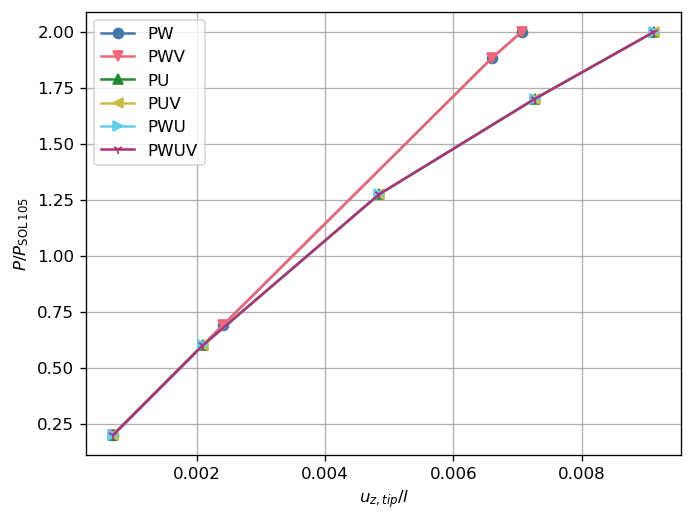

In [17]:
nlparm_id = next(iter(box_beam_bdf.nlparms))  # retrieve id of NLPARM card
_, ax = plt.subplots()  # create figure with one subplot

# Run analysis for each set of error functions and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    box_beam_bdf.nlparms[nlparm_id].conv = fun
    input_name = 'nonlinear_analysis_error_function_' + fun
    plot_load_displacement_diagram(box_beam_bdf, input_name, ax, markers[count], f"{fun}", run_flag=False)

# Set plot appearance
plt.xlabel("$u_{z, tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\,105}$")
plt.legend()
plt.grid()
plt.show()

The results appear to be different when the displacement function is included in the error functions, while the vector component checking does not seem to have any influence. The load-displacement curves obtained with the displacement function included in the error functions have a better resolution than the other curves (5 equilibrium points instead of 4), and they also show a nonlinear behavior, which is not present in the other curves.

For these reasons, we decide to include the displacement function in the error functions for the rest of our analyses. We choose to use the combination of load and displacement functions without vector component checking, since our last analysis does not show any difference when the energy function or the vector component checking are included.

In [18]:
box_beam_bdf.nlparms[nlparm_id].conv = 'PU'

### Convergence tolerance <a name="convergence-tolerance"></a>

The second parameter that we consider is the convergence tolerance. Let's take three different combinations of load and displacement tolerances, taken from [table 21](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/qrg/bulkno/TOC.NLPARM.xhtml) of MSC Nastran *Quick Reference Guide* manual on the default tolerances for static nonlinear SOL 106 models:
- $EPSP=10^{-1}$, $EPSU=10^{-1}$;
- $EPSP=10^{-2}$, $EPSU=10^{-2}$ (default);
- $EPSP=10^{-3}$, $EPSU=10^{-3}$.

Let's define the list of convergence tolerances, run the analyses and visualize the results.

Nastran job nonlinear_analysis_load_tolerance_1e-01.bdf completed
Wall time: 16.0 s


Nastran job nonlinear_analysis_load_tolerance_1e-02.bdf completed
Wall time: 20.0 s


Nastran job nonlinear_analysis_load_tolerance_1e-03.bdf completed
Wall time: 21.0 s


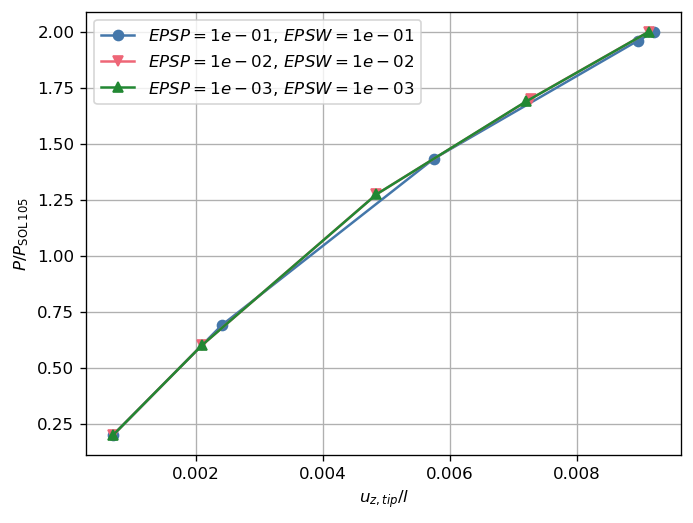

In [19]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
displacement_tolerances = [1e-1, 1e-2, 1e-3]

# Create figure, run analysis for each couple of convergence tolerances and plot load-displacement diagram
_, ax = plt.subplots()
for count, epsp in enumerate(load_tolerances):
    epsu = displacement_tolerances[count]
    box_beam_bdf.nlparms[nlparm_id].eps_p = epsp
    box_beam_bdf.nlparms[nlparm_id].eps_u = epsu
    input_name = f"nonlinear_analysis_load_tolerance_{epsp:.0e}".replace('.','_')
    plot_load_displacement_diagram(box_beam_bdf, input_name, ax, markers[count], f"$EPSP={epsp:.0e},\,EPSW={epsu:.0e}$", run_flag=False)

# Set plot appearance
plt.xlabel("$u_{z, tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\,105}$")
plt.legend()
plt.grid()
plt.show()

The three curves seem to describe the same equilibrium path. However, the curve with the least tight tolerances appears to predict a slightly larger final displacement than the other two curves. Furthermore, even if all curves are made by 5 equilibrium points, the curves with intermediate and tightest tolerances present a resolution that is better spread along investigated load range.

Since we do not notice a substantial difference between the intermediate and the tighest tolerances, we decide to use the intermediate tolerances for the rest of our analyses.

In [20]:
box_beam_bdf.nlparms[nlparm_id].eps_p = 1e-2
box_beam_bdf.nlparms[nlparm_id].eps_u = 1e-2


### Initial load increment <a name="initial-load-increment"></a>

Now we consider three different values of initial load increment:
- $\Delta\mu^1=0.5$;
- $\Delta\mu^1=0.1$ (default);
- $\Delta\mu^1=0.01$.

Nastran job nonlinear_analysis_initial_load_increment_5e-01.bdf completed
Wall time: 16.0 s


Nastran job nonlinear_analysis_initial_load_increment_1e-01.bdf completed
Wall time: 19.0 s


Nastran job nonlinear_analysis_initial_load_increment_1e-02.bdf completed
Wall time: 23.0 s


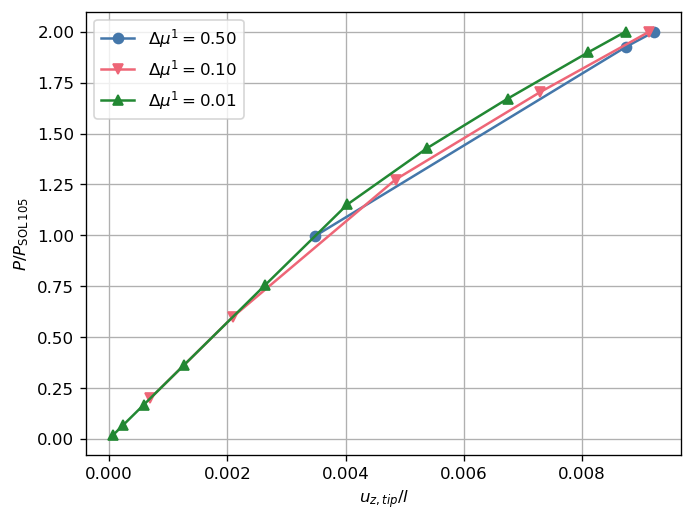

In [21]:
initial_load_increments = [.5, .1, .01]  # define list of initial load increments

# Create figure, run analysis for each initial load increment and plot load-displacement diagram
_, ax = plt.subplots()
for count, delta_mu_1 in enumerate(initial_load_increments):
    box_beam_bdf.nlparms[nlparm_id].ninc = int(1/delta_mu_1)
    input_name = f"nonlinear_analysis_initial_load_increment_{delta_mu_1:.0e}".replace('.','_')
    plot_load_displacement_diagram(box_beam_bdf, input_name, ax, markers[count], f"$\Delta\mu^1={delta_mu_1:.2f}$", run_flag=False)

# Set plot appearance
plt.xlabel("$u_{z, tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\,105}$")
plt.legend()
plt.grid()
plt.show()

The three curves seem to describe the same equilibrium path for $P/P_\text{SOL 105}\leq1$, while beyond the linear buckling load there is a clear difference, which can also be observed in the final displacements. Since the smallest initial load increment results in curve with the highest resolution, we keep $\Delta\mu^1=0.01$ for our successive analyses.

### Desired number of iterations <a name="desiter"></a>

Now we investigate the influence of the desired number of iterations, using the following values:
- $DESITER=20$;
- $DESITER=12$ (default);
- $DESITER=5$.

Nastran job nonlinear_analysis_desiter_20.bdf completed
Wall time: 23.0 s


Nastran job nonlinear_analysis_desiter_12.bdf completed
Wall time: 24.0 s


Nastran job nonlinear_analysis_desiter_5.bdf completed
Wall time: 32.0 s


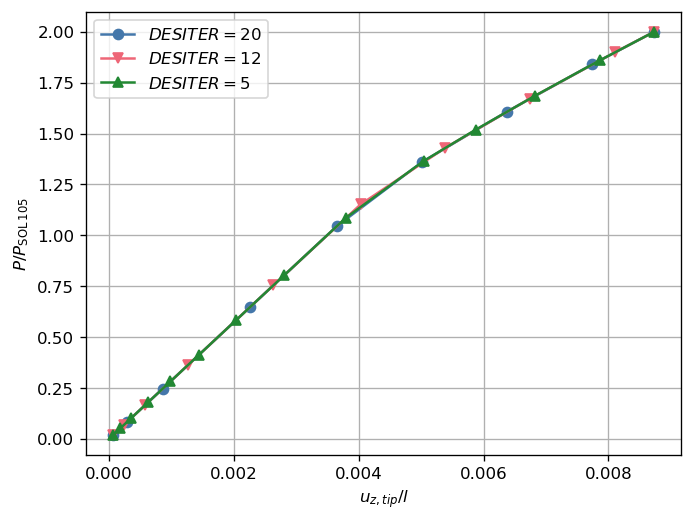

In [22]:
no_iterations = [20, 12, 5]  # define list of desired numbers of iterations

# Create figure, run analysis for each desired number of iterations, plot load-displacement diagram
_, ax = plt.subplots()
for count, desiter in enumerate(no_iterations):
    box_beam_bdf.nlpcis[nlparm_id].desiter = desiter
    input_name = f"nonlinear_analysis_desiter_{desiter:d}"
    plot_load_displacement_diagram(box_beam_bdf, input_name, ax, markers[count], f"$DESITER={desiter}$", run_flag=False)

# Set plot appearance
plt.xlabel('$u_{z, tip}/l$')
plt.ylabel('$P/P_\mathrm{SOL\,105}$')
plt.legend()
plt.grid()
plt.show()

The three curves appear to describe the same equilibrium path. Since the smallest desired number of iteration results in a fine resolution of the load-displacement curve, we keep $DESITER=5$ for our further analyses.

### Minimum allowable arc-length adjustment ratio <a name="minalr"></a>

Next, we assess the effect of the minimum allowable arc-length adjustment ratio, investigating three values:
- $MINALR=0.9$;
- $MINALR=0.25$ (default);
- $MINALR=0.01$.

Nastran job nonlinear_analysis_minalr_0_90.bdf completed
Wall time: 34.0 s


Nastran job nonlinear_analysis_minalr_0_25.bdf completed
Wall time: 35.0 s


Nastran job nonlinear_analysis_minalr_0_01.bdf completed
Wall time: 39.0 s


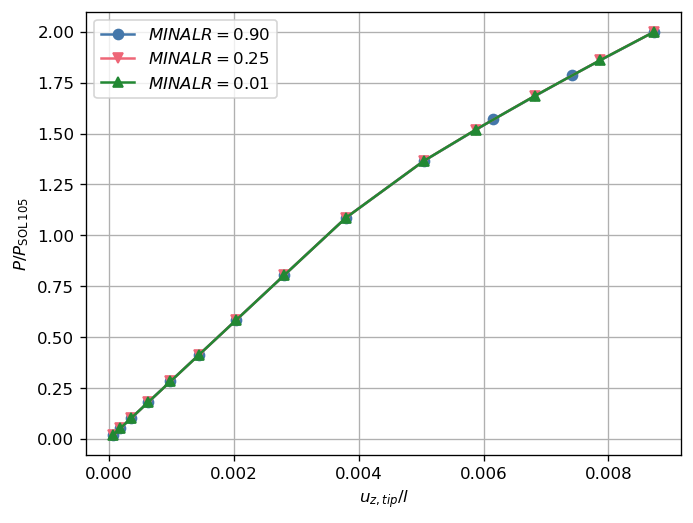

In [23]:
min_arclength_adjustment_ratios = [.9, .25, .01]  # define list of minimum allowable arc-length adjustment ratios

# Create figure, run analysis for each minimum allowable arc-length adjustment ratio and plot load-displacement diagram
_, ax = plt.subplots()
for count, minalr in enumerate(min_arclength_adjustment_ratios):
    box_beam_bdf.nlpcis[nlparm_id].minalr = minalr
    input_name = f"nonlinear_analysis_minalr_{minalr:.2f}".replace('.','_')
    plot_load_displacement_diagram(box_beam_bdf, input_name, ax, markers[count], f"$MINALR={minalr:.2f}$", run_flag=False)

# Set plot appearance
plt.xlabel('$u_{z, tip}/l$')
plt.ylabel('$P/P_\mathrm{SOL\,105}$')
plt.legend()
plt.grid()
plt.show()

In this case we cannot see any effect on the load-displacement curve,  so we switch back to the default value.

In [24]:
box_beam_bdf.nlpcis[nlparm_id].minalr = .25

### Maximum allowable arc-length adjustment ratio <a name="maxalr"></a>

Finally, we consider three different maximum allowable arc-length adjustment ratios:
- $MAXALR=10$;
- $MAXALR=4$ (default);
- $MAXALR=1.01$.

Before running the analyses, we increase the maximum number of allowed increments in each subcase to 100, in order to avoid the solver to stop the analysis before reaching the desired applied load.

Nastran job nonlinear_analysis_maxalr_10_00.bdf completed
Wall time: 42.0 s


Nastran job nonlinear_analysis_maxalr_4_00.bdf completed
Wall time: 35.0 s


Nastran job nonlinear_analysis_maxalr_1_01.bdf completed
Wall time: 137.0 s


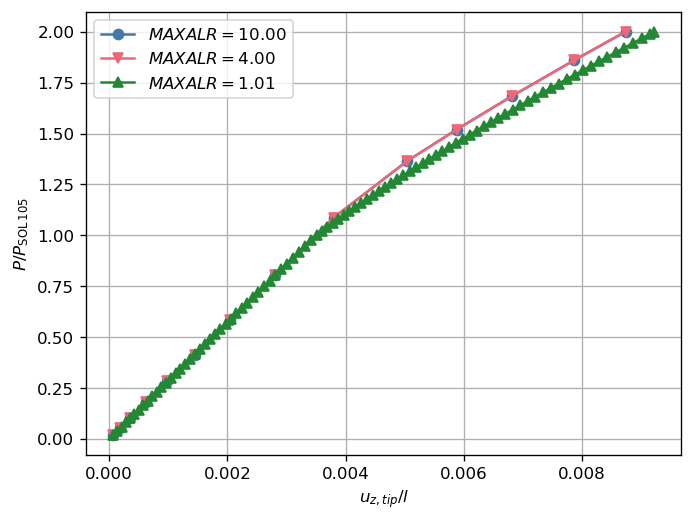

In [25]:
max_arclength_adjustment_ratios = [10., 4., 1.01]  # define list of maximum allowable arc-length adjustment ratios
box_beam_bdf.nlpcis[nlparm_id].mxinc = 100  # increase maximum number of allowed load increments

# Create figure, run analysis for each maximum allowable arc-length adjustment ratio and plot load-displacement diagram
_, ax = plt.subplots()
for count, maxalr in enumerate(max_arclength_adjustment_ratios):
    box_beam_bdf.nlpcis[nlparm_id].maxalr = maxalr
    input_name = f"nonlinear_analysis_maxalr_{maxalr:.2f}".replace('.','_')
    plot_load_displacement_diagram(box_beam_bdf, input_name, ax, markers[count], f"$MAXALR={maxalr:.2f}$", run_flag=False)

# Set plot appearance
plt.xlabel("$u_{z, tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL\,105}$")
plt.legend()
plt.grid()
plt.show()

Similarly to the case of the initial load increment, and more evidently here, the three curves appear to describe the same equilibrium path for $P/P_\text{SOL 105}<1$, while beyond the linear buckling load there is a clear difference between the curve with the smallest value of $MAXALR$ and the other two curves. This can be noticed also in the final value of tip displacement.

We choose to keep the value that results in the most resolved load-displacement curve, that is to say $MAXALR=1.01$.

With our final set of nonlinear analysis parameter chosen, we can make a final observation on the load-displacement diagram. The curve appears to be linear below and above $P/P_\text{SOL 105}=1$ with a clear kink at such applied load. This evidence suggests that some nonlinearity has come into play. For this reason we inspect the static deformation of the box beam for $P/P_\text{SOL 105}=2$.

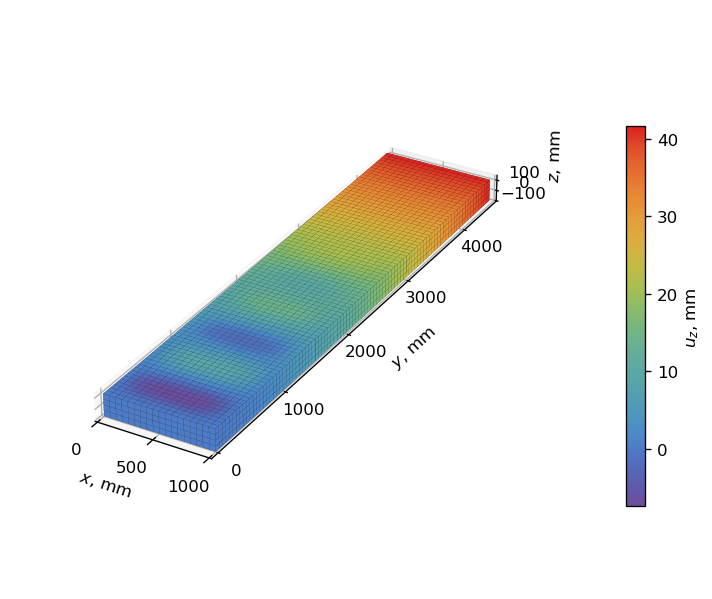

In [26]:
input_name = f"nonlinear_analysis_maxalr_{max_arclength_adjustment_ratios[-1]:.2f}".replace('.','_')
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
sol_106_op2 = read_op2(op2_filepath, debug=None, load_geometry=True)
_, ax, cbar = pynastran_utils.plot_static_deformation(sol_106_op2, displacement_component='tz')
adjust_3d_plot(ax, cbar)
plt.show()

We observe that the top skin has indeed assumed a buckled-like shape, with alternating positive and negative out-of-plane displamecements over the rib bays along the inboard region of the box beam. Consequently, the change of slope in the load-displacement diagram can be ascribed to the change of shape of the structure as it is loaded beyond $P/P_\text{SOL 105}=1$.

## Nonlinear analysis: nonlinear buckling method verification <a name="nonlinear-buckling-method-verification"></a>

***

The next step of our study consists in the verification of SOL 106's nonlinear buckling method and of the stability of the equilibrium path found earlier. As far as the former is concerned, we want to verify whether the nonlinear buckling method is able to predict the same buckling load predicted by SOL 105 for the linear range of the structural response, that is to say for $P/P_\text{SOL 105}<1$. For the latter, we need to monitor the lowest eigenvalue of the tangent stiffness matrix and check that it is always positive.

Similarly to what we did for the [unreinforced box beam](06_Verification_of_SOL_106_Nonlinear_Buckling_Method.ipynb), we define 11 load magnitudes equally spaced between 0 and twice the linear buckling load. We discard the load case with null magnitude, we keep the other 10 load cases and define the corresponding subcases.

In [27]:
# Define and print the sequence of increasing applied loads
applied_load_magnitudes = np.linspace(0, 2*sol_105_buckling_load, 11)[1:]
np.set_printoptions(precision=0, suppress=True)
print(f"Applied loads [N]: {applied_load_magnitudes}")

# Change first load magnitude of first subcase
box_beam_bdf.load_combinations[load_set_id][0].scale_factors[0] = applied_load_magnitudes[0]

# Create LOAD card and corresponding subcases for remaining applied loads
for i, scale_factor in enumerate(applied_load_magnitudes[1:], start=2):
    load_set_id = load_set_id + 1
    box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])
    pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=i, load_set_id=load_set_id)

Applied loads [N]: [ 620. 1240. 1861. 2481. 3101. 3721. 4341. 4962. 5582. 6202.]


We add the parameters needed to execute the nonlinear buckling method.

In [28]:
box_beam_bdf.add_param('BUCKLE', [2])
eigrl_set_id = load_set_id + 1
box_beam_bdf.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)  # calculate only the first positive eigenvalue with the Lanczos method
box_beam_bdf.case_control_deck.subcases[0].add_integer_type('METHOD', eigrl_set_id)

We add the DMAP sequence to calculate the lowest eigenvalue of the tangent stiffness matrix at converged every iteration.

In [29]:
box_beam_bdf.executive_control_lines[1:1] = ['include \'' + os.path.join(os.pardir, os.pardir, 'resources', 'kllrh_lowest_eigenvalues.dmap') + '\'']  # include DMAP sequence

And we can finally run our nonlinear analysis.

In [30]:
input_name = 'nonlinear_buckling_verification'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=box_beam_bdf, filename=input_name, run_flag=False)

Nastran job nonlinear_buckling_verification.bdf completed
Wall time: 1460.0 s


Let's plot the results in terms of the nonlinear buckling loads and critical buckling factors predicted by SOL 106 against the applied load.

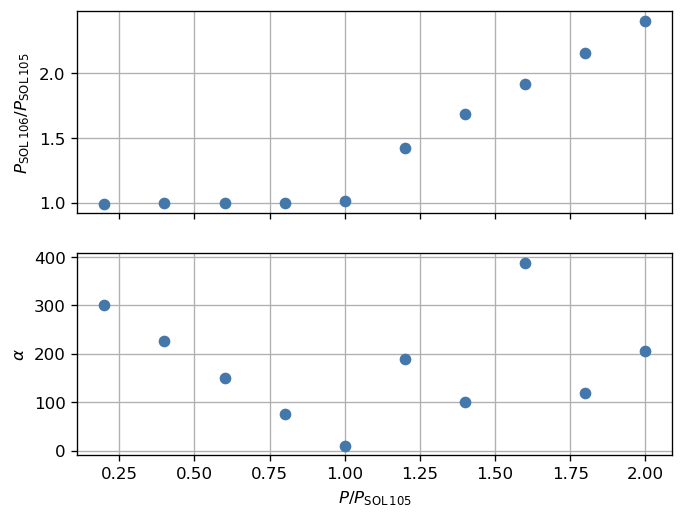

In [31]:
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_load_vectors, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(
    f06_filepath=os.path.join(analysis_directory_path, input_name + '.f06'), op2_object=sol_106_op2)  # read buckling loads and critical buckling factors from f06 file
sol_106_buckling_loads = np.linalg.norm(np.sum(nonlinear_buckling_load_vectors[:, :, 0:3], axis=1), axis=1)  # calculate the norm of the nonlinear buckling load vector for each subcase

# Plot results
_, axs = plt.subplots(nrows=2, ncols=1, sharex='all')  # figure with 2 subplots
axs[0].plot(applied_load_magnitudes/sol_105_buckling_load, sol_106_buckling_loads/sol_105_buckling_load, 'o')  # buckling loads vs applied loads
axs[1].plot(applied_load_magnitudes/sol_105_buckling_load, critical_buckling_factors, 'o')  # critical buckling factors vs applied loads

# Set plot appearance
axs[0].set_ylabel("$P_\mathrm{SOL\,106}/P_\mathrm{SOL\,105}$")
axs[0].grid(visible=True)
axs[1].set_ylabel("$\\alpha$")
axs[1].grid(visible=True)
axs[1].set_xlabel("$P/P_\mathrm{SOL\,105}$")
plt.show()

For $P/P_\text{SOL 105}<1$ the nonlinear buckling method predicts the same critical buckling load of SOL 105, as we would expect. For $P/P_\text{SOL 105}\geq1$ we observe a nearly linear trend of the nonlinear buckling load with the applied load. These results are analogous to the results of the unreinforced box beam. Consequently, also in this case, the results suggest that the structure follows an equilibrium path analogous to the natural path of the broken supercritical pitchfork.

Let's plot the load-displacement diagram and the lowest eigenvalue $\lambda$ of the tangent stiffness matrix against the applied load to verify that the structure is always in a stable equilibrium.

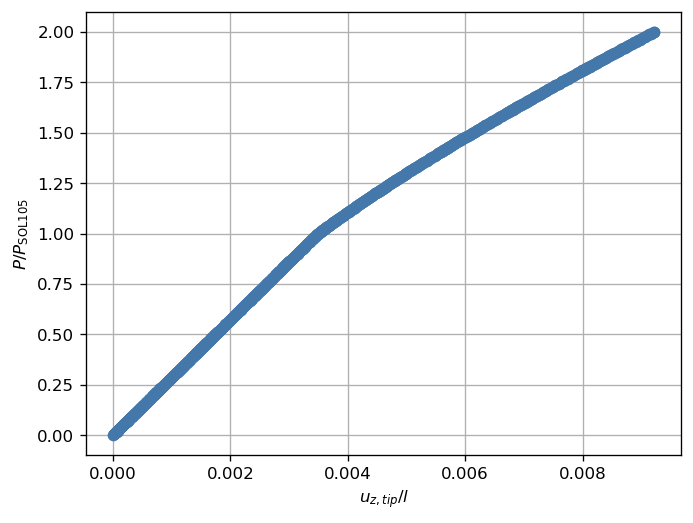

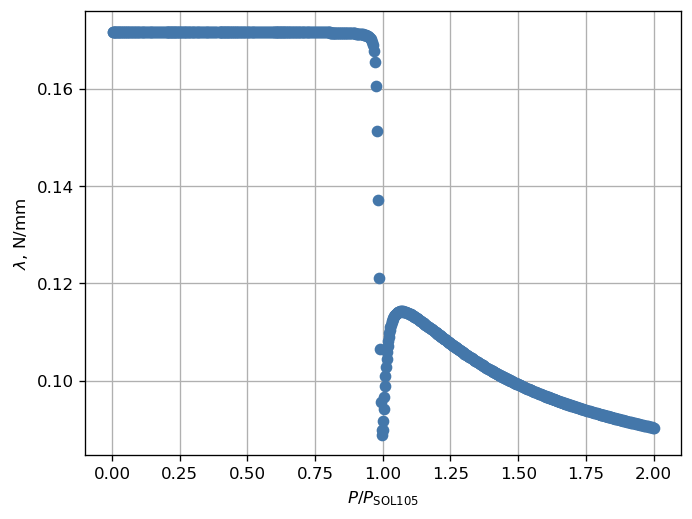

In [32]:
# Plot load-displacement diagram
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=tip_master_node_id)  # read load and displacement history
load_history = np.concatenate([applied_loads[subcase_id][:, load_component_index] for subcase_id in applied_loads])
displacement_history = np.concatenate([tip_displacements[subcase_id][:, displacement_component_index] for subcase_id in tip_displacements])
_, ax = plt.subplots()
ax.plot(displacement_history/l, load_history/sol_105_buckling_load, 'o')
plt.xlabel("$u_{z, tip}/l$")
plt.ylabel("$P/P_\mathrm{SOL 105}$")
plt.grid()
plt.show()

# Plot lowest eigenvalue of tangent stiffness matrix
f06_filepath = os.path.join(analysis_directory_path, input_name + '.f06')  # path to .f06 file
lowest_eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)  # read eigenvalues from f06 files
_, ax = plt.subplots()
ax.plot(load_history/sol_105_buckling_load, lowest_eigenvalues[0, :], 'o')
plt.xlabel("$P/P_\mathrm{SOL 105}$")
plt.ylabel("$\lambda$, N/mm")
plt.grid()
plt.show()

The lowest eigenvalue is constant up to a load slightly smaller than $P/P_\text{SOL 105}=1$, where it undergoes an abrupt decrease. This must correspond to the top skin assuming a buckled-like shape and consequently inducing a nonlinearity in the global behavior of the structure, as we can observe in the load-displacement diagram. However, the lowest eigenvalue does not become null or negative, meaning that the structure does not encounter a critical point and that it always stays in a stable equilibrium configuration.

## Conclusion <a name="conclusion"></a>

***

In this notebook we have analyzed the nonlinear buckling behavior of a box beam reinforced with ribs. We found that the structure exhibits a linear behavior for an applied load below the linear buckling load predicted by SOL 105. When such load is exceeded, the box beam shows a nonlinear softening beahvior in the load-displacement diagram. This is caused by the deformation of the top skin, which assumes a buckled-like shape. When we looked at the lowest eigenvalue of the tangent stiffness matrix we found it to be always positve, meaning that there is no critical point in the equilibrium path followed in our analysis and that the structure is always in a stable equilibrium. This suggests that a reinforced box beam loaded in bending follows an equilibrium path analogous to the natural path of the broken supercritical pitchfork of the Euler's column, similarly to what we found for the unreinforced box beam.